In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import math
import os
import datetime
import itertools

import corner

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Neural network
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

2024-06-23 23:37:51.358861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
galaxyquasar = pd.read_csv('galaxyquasar.csv')

galaxyquasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
# Convert to NaN any np.inf or '' value
galaxyquasar[(galaxyquasar == np.inf) | (galaxyquasar == '')] = np.nan

# Count NaN in the data set
np.sum(galaxyquasar.notna() == False, axis=0)

u        0
g        0
r        0
i        0
z        0
class    0
z1       0
zerr     0
dtype: int64

In [4]:
le = LabelEncoder()

# Convert the Star type into integers indexes
galaxyquasar['class'] = le.fit_transform(galaxyquasar['class'])

galaxyquasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [5]:
# Keep also the string labels
classes = le.inverse_transform(galaxyquasar['class'])

# Save the classes names
class_names = le.classes_
print(class_names)

['GALAXY' 'QSO']


In [6]:
# Make labels for new variables
colors_labels = ['u-g', 'g-r', 'r-i', 'i-z']
colors_indexes = dict(zip(colors_labels, range(len(colors_labels))))

# Make a matrix for the new variables
colors = np.zeros((len(galaxyquasar), len(colors_labels)))

# Fill the matrix
for lb, i in zip(colors_labels, range(len(colors_labels))):
    l1, l2 = lb.split('-')
    colors[:, i] = galaxyquasar[l1] - galaxyquasar[l2]

colors.shape

(50000, 4)

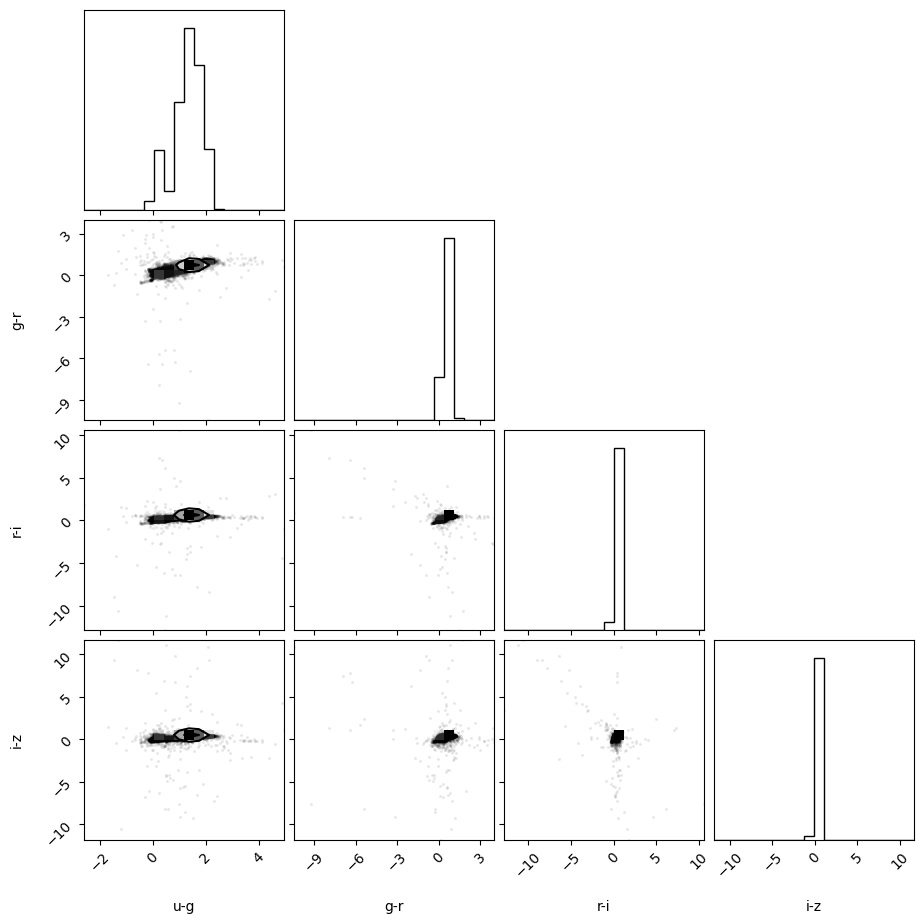

In [7]:
# Plot the distributions of the colors
corner.corner(colors, labels=colors_labels)

# Otherwise it plots it twice
plt.show()

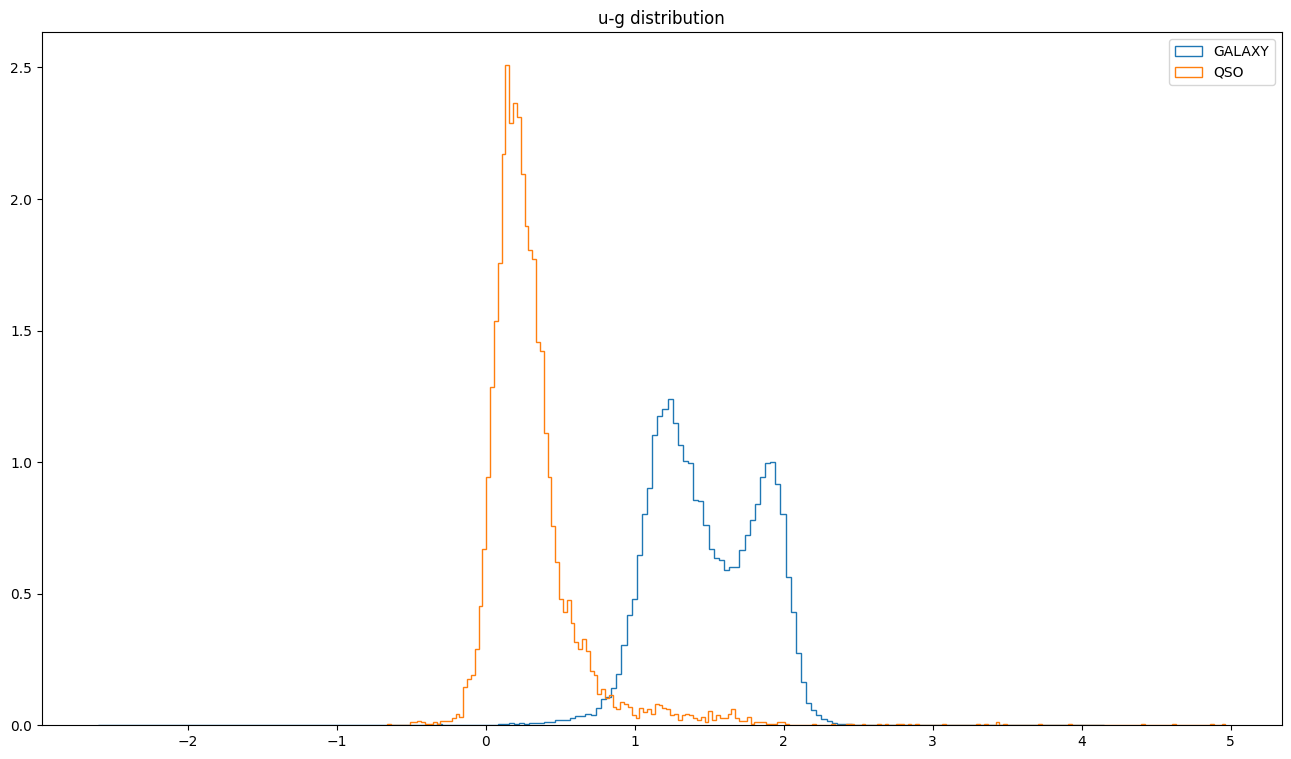

In [8]:
# Plot the u-g color distribution
fig, ax = plt.subplots(figsize = (16, 9))

ax.set_title("u-g distribution")

for cl in class_names:
    ax.hist(colors[:, colors_indexes['u-g']][classes == cl],
            bins='auto', density=True, histtype='step', label=cl)
    
ax.legend()

plt.show()

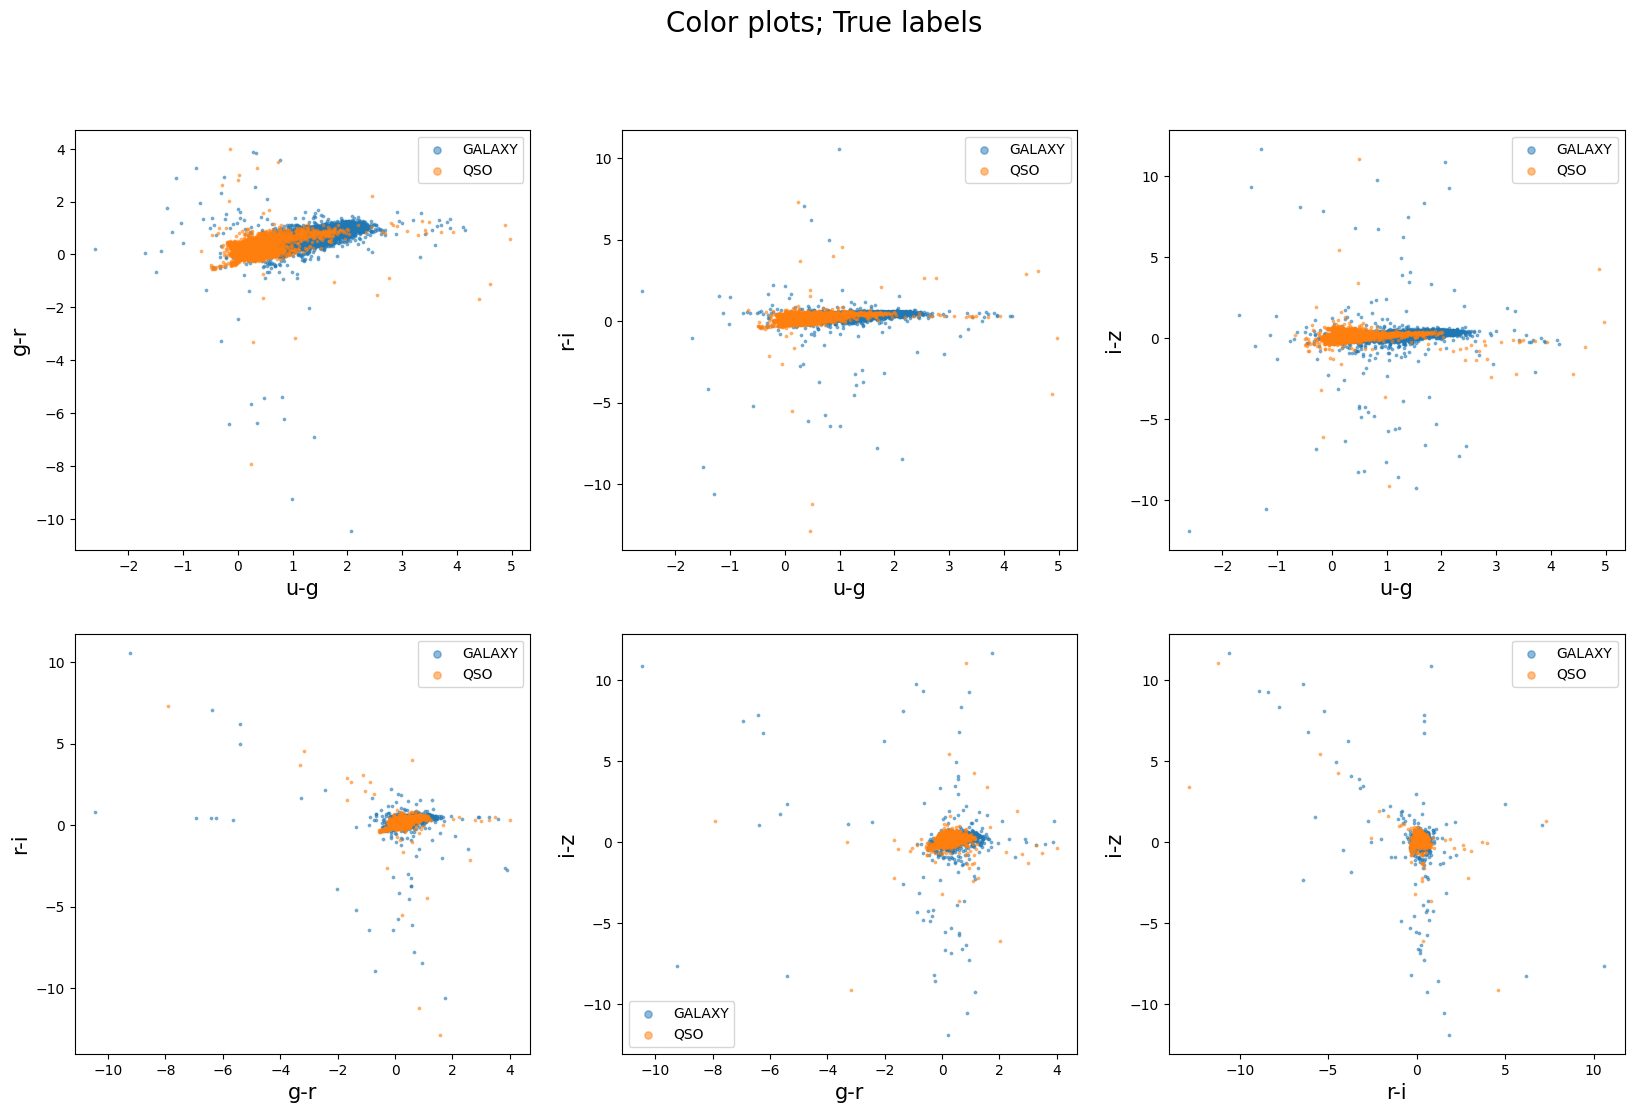

In [9]:
# Plot every components combination
fig = plt.figure(figsize=(20, 12))

fig.suptitle("Color plots; True labels", size=20)

# Compute the number of plots needed to represent every possible combination
# of 2 of the colors: n(n-1)/2. n = 4 ---> 6 plots
n_plots = int(len(colors_labels) * (len(colors_labels) - 1) / 2)

index = 1
for i in range(len(colors_labels)):
    for j in range(i + 1, len(colors_labels)):
        ax = fig.add_subplot(math.ceil(n_plots / 3), 3, index)
        ax.set_xlabel(colors_labels[i], size=15)
        ax.set_ylabel(colors_labels[j], size=15)

        # Plot the classes separately
        for cl in class_names:
             ax.scatter(colors[:, i][classes == cl],
                        colors[:, j][classes == cl],
                        alpha=0.5, label=cl, s=3)
             
        ax.legend(markerscale=3)
        
        index += 1

plt.show()

In [10]:
# Standardize data
scaler = StandardScaler()
std_colors = scaler.fit_transform(colors)

In [11]:
# Split the standardized data into a training set and a test set
training_set, test_set, training_target, test_target = \
    train_test_split(std_colors, galaxyquasar['class'], train_size=0.7)

print(training_set.shape, test_set.shape, training_target.shape, test_target.shape)

(35000, 4) (15000, 4) (35000,) (15000,)


In [12]:
# Make the NN model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(units=5, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(rate=0.5), # Regularization
    tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Fit the NN model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(training_set, training_target, validation_split=0.3, epochs=5)

Epoch 1/5
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8594 - loss: 0.4412 - val_accuracy: 0.9696 - val_loss: 0.1918
Epoch 2/5
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9115 - loss: 0.2335 - val_accuracy: 0.9780 - val_loss: 0.1326
Epoch 3/5
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9168 - loss: 0.1887 - val_accuracy: 0.9792 - val_loss: 0.1114
Epoch 4/5
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9188 - loss: 0.1673 - val_accuracy: 0.9808 - val_loss: 0.1060
Epoch 5/5
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9161 - loss: 0.1769 - val_accuracy: 0.9812 - val_loss: 0.1022


In [15]:
# Evaluate the model on the test set
model.evaluate(test_set, test_target)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9822 - loss: 0.1021


[0.10336347669363022, 0.980400025844574]

In [16]:
# Repeat using the predict() method.
# Returns probabilities for the classes
# In this case return the probability of having class "1"
predicts_proba = model.predict(test_set)
print(predicts_proba.shape, predicts_proba.dtype)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
(15000, 1) float32


In [17]:
# Convert the probabilities to integer labels
predicts_labels = (np.squeeze(predicts_proba) > 0.5).astype(int)
print(predicts_labels.shape, predicts_labels.dtype)

(15000,) int64


ACCURACY = 0.9804
CONFUSION MATRIX:
[[12793    60]
 [  234  1913]]


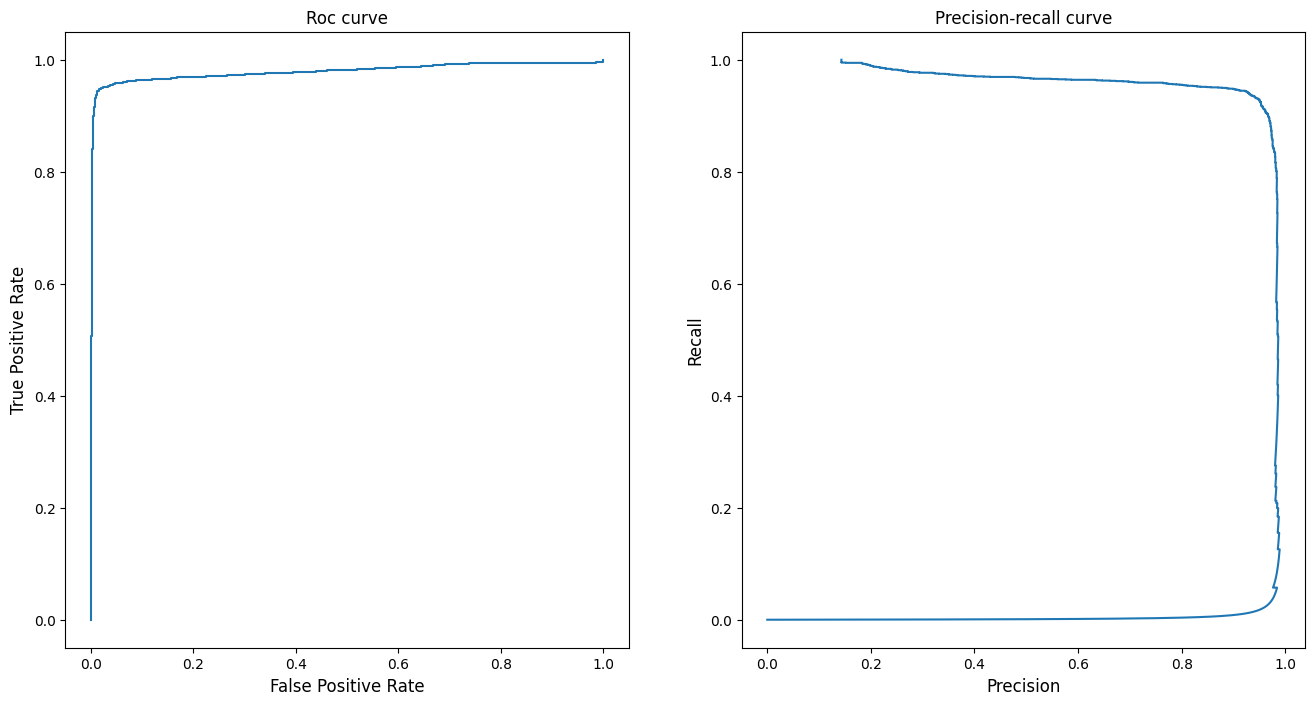

In [18]:
# Print some inormations and plot ROC curves and precision-recall curves
print("ACCURACY = {acc}\n"
      "CONFUSION MATRIX:\n"
      "{conf_mat}".format(acc=accuracy_score(test_target, predicts_labels),
                          conf_mat=confusion_matrix(test_target, predicts_labels)))

# Compute ROC and precision-recall curves
fpr, tpr, thresholds = roc_curve(test_target, predicts_proba, pos_label=1)
prec, rec, thresholds = precision_recall_curve(test_target, predicts_proba, pos_label=1)

# Plot the curves
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].set_title("Roc curve")
axes[0].set_xlabel("False Positive Rate", size=12)
axes[0].set_ylabel("True Positive Rate", size=12)
axes[0].plot(fpr, tpr)

axes[1].set_title("Precision-recall curve")
axes[1].set_xlabel("Precision", size=12)
axes[1].set_ylabel("Recall", size=12)
axes[1].plot(prec[:-1], rec[:-1])

plt.show()

The model would also require some hyperparameters optimization. Basically I should check which model performs the best when using different combinations of the number of neurons, activation functions, loss functions, optimizers, learning rates, dropout rates, ecc..

With TensorFlow, this can be done with the help of the TensorBoard plugin, which is a visualization tool for the neural network.

However, its worth to notice that the results obtained with this simple neural network, resembles the results from L19 exercise.